# Working with 3rd party (detached) Prompts/Prompt Template Assets(Cloud)


This notebook should be run using with Runtime 22.2 & Python 3.10 or greater runtime environment, if you are viewing this in Watson Studio, and do not see Python 3.10.x in the upper right corner of your screen, please update the runtime now. 

The notebook will create a retrieval augmented generation prompt template asset in a given project, configure OpenScale to monitor that PTA and evaluate generative quality metrics and model health metrics. This notebook has data which is memory centric

If users wish to execute this notebook for task types other than retrieval_augmented_generation, please consult [this](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md) document for guidance on evaluating prompt templates for the available task types.

Note : User can search for `EDIT THIS` and fill the inputs needed.

## Prerequisite

* It requires service credentials for IBM Watson OpenScale:
* Requires a CSV file containing the test data that needs to be evaluated
* Requires the ID of project in which you want to create the prompt template asset.

### Contents

- [Setup](#settingup)
- [Create Prompt template](#prompt)
- [Prompt Setup](#ptatsetup)
- [Risk evaluations for prompt template asset subscription](#evaluate)
- [Display the Model Risk metrics](#mrmmetric)
- [Display the Generative AI Quality metrics](#genaimetrics)
- [Plot rougel and rougelsum metrics against records](#plotproject)
- [See factsheets information](#factsheetsspace)

## Setup <a name="settingup"></a>

In [1]:
!pip install --upgrade datasets==2.10.0 --no-cache | tail -n 1
!pip install --upgrade evaluate --no-cache | tail -n 1
!pip install --upgrade ibm-aigov-facts-client | tail -n 1
!pip install --upgrade ibm-watson-openscale | tail -n 1
!pip install --upgrade matplotlib | tail -n 1
!pip install --upgrade pydantic==1.10.11 --no-cache | tail -n 1
!pip install --upgrade sacrebleu --no-cache | tail -n 1
!pip install --upgrade sacremoses --no-cache | tail -n 1
!pip install --upgrade textstat --no-cache | tail -n 1
!pip install --upgrade transformers --no-cache | tail -n 1

Note: you may need to restart the kernel to use updated packages.

### Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [3]:
IAM_URL = "https://iam.cloud.ibm.com"
DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
SERVICE_URL = "https://api.aiopenscale.cloud.ibm.com"
CLOUD_API_KEY = "<EDIT THIS>" # YOUR_CLOUD_API_KEY
WML_CREDENTIALS = {
                "url": "https://us-south.ml.cloud.ibm.com",
                "apikey": CLOUD_API_KEY
}

## Set the project ID

In order to set up a development type subscription, the PTA must be within the project. Please supply the project ID where the PTA needs to be created.

In [4]:
PROJECT_ID = "<EDIT THIS>" # YOUR_PROJECT_ID

## Read space id from user

User can use an existing space or can create a new space to promote the model. User should choose any of these options with the below variable.

In [5]:
use_existing_space = True # Set it as False if user wants to create a new space

In [6]:
import json
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

'1.0.360'

### Below details are required only if user choose to use an existing space

In order to use an existing space, User can directly add the space id in the below cell

In [ ]:
wml_client.spaces.list()

In [8]:
existing_space_id = "<EDIT THIS>" # YOUR_SPACE_ID

### Below details are required only if user choose to create a new space

In [8]:
space_name = "<EDIT THIS>" # YOUR_SPACE_NAME

Tip: `WML_INSTANCE_NAME`, `WML_CRN` and `COS_RESOURCE_CRN` are required only if you are pointing to your cloud openscale instance, Your `WML_INSTANCE_NAME` and `WML_CRN` can be read from the [Cloud console](https://cloud.ibm.com/resources). From that page, goto `Resours list`, Copy the name of your WML instance listed there. Select the row corresponding to your WML instance, and copy the CRN displayed in the popup on the right side of the page

In [9]:
#####################################################################################
# Paste your WML_INSTANCE_NAME, WML CRN in the following field and then run this cell.
######################################################################################
WML_INSTANCE_NAME =  "<EDIT THIS>" # YOUR_WML_INSTANCE_NAME
WML_CRN =  "<EDIT THIS>" # YOUR_WML_CRN

In next cell, you will need to paste COS_RESOURCE_CRN. If you haven't worked with COS yet please visit [getting started with COS tutorial](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-getting-started-cloud-object-storage).
You can find COS_RESOURCE_CRN variable in Service Credentials in menu of your COS instance.

In [10]:
COS_RESOURCE_CRN = "<EDIT THIS>"

### Setting up the space

In [9]:
if use_existing_space == True:
    space_id = existing_space_id
else:
    space_meta_data = {
        wml_client.spaces.ConfigurationMetaNames.NAME: space_name,
        wml_client.spaces.ConfigurationMetaNames.STORAGE: {"resource_crn":COS_RESOURCE_CRN},
        wml_client.spaces.ConfigurationMetaNames.COMPUTE: {"name": WML_INSTANCE_NAME, "crn": WML_CRN},
        wml_client.spaces.ConfigurationMetaNames.TYPE: "wx"
    }

    space_id = wml_client.spaces.store(
        meta_props=space_meta_data)["metadata"]["id"]
wml_client.set.default_space(space_id)
print(space_id)

a4a76fad-a549-43cd-9d1d-2c17b15f009e


## Function to create the access token

This function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [10]:
import requests, json
def generate_access_token():
    headers={}
    headers["Content-Type"] = "application/x-www-form-urlencoded"
    headers["Accept"] = "application/json"
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": CLOUD_API_KEY,
        "response_type": "cloud_iam"
    }
    response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
    json_data = response.json()
    iam_access_token = json_data["access_token"]
        
    return iam_access_token

iam_access_token = generate_access_token()

# Demo Dataset <a name="alternative"></a>


Used as alternative to be run for testing in low resource CPD clusters


In [ ]:
!wget https://ibm.box.com/shared/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv


--2024-08-08 14:59:42--  https://ibm.box.com/shared/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv
Resolving ibm.box.com (ibm.box.com)... 74.112.186.157
Connecting to ibm.box.com (ibm.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv [following]
--2024-08-08 14:59:43--  https://ibm.box.com/public/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv [following]
--2024-08-08 14:59:43--  https://ibm.ent.box.com/public/static/3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv
Resolving ibm.ent.box.com (ibm.ent.box.com)... 74.112.186.157
Connecting to ibm.ent.box.com (ibm.ent.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [12]:
!mv 3ysiqmcqzemlbp68pc7dg7homj5jjztt.csv RAG_data.csv

In [13]:
import pandas as pd

test_data_path = "RAG_data.csv"
llm_data = pd.read_csv(test_data_path)
llm_data=llm_data.head(10)


In [14]:
llm_data.to_csv(test_data_path)

In [15]:
llm_data

,question,generated_text,answer,context1,context2,context3
0,"After cancelling policy , how long we have to ...","If you cancel your policy, you can still make ...","Sorry, I don't have information on that.","\n<t1></t1>\nAt Bingle, we don't have the opti...",\n<t2></t2>\nWeâ€™re sorry to hear your car ha...,"\n<t3></t3>\nCompulsory Third Party Insurance,..."
1,Am I covered for asbestos in my vehicle?,"We will not cover asbestos, asbestos fibres or...","We will not cover asbestos, asbestos fibres or...",\n<t1></t1>\nâ€¢ We will not cover incidents o...,"\n<t2></t2>\nYes, if youâ€™re a salesperson, r...",\n<t3></t3>\nBingle offers third party propert...
2,Am I covered for bushfires,Our Comprehensive Car Insurance covers acciden...,Our Comprehensive Car Insurance covers acciden...,\n<t1></t1>\nMother Nature can be harsh at tim...,\n<t2></t2>\nWe will cover liability which is ...,\n<t3></t3>\nâ€¢ We will not cover incidents o...
3,Am I covered for every car I drive?,Your policy only covers you for the specific c...,Your policy only covers you for the specific c...,\n<t1></t1>\nWeâ€™re happy to cover licenced d...,\n<t2></t2>\nâ€¢ If your car cannot be driven ...,"\n<t3></t3>\nTo add hire car to your policy, y..."
4,Am I covered for fire?,Our Comprehensive Car Insurance covers acciden...,Our Comprehensive Car Insurance covers acciden...,\n<t1></t1>\nMother Nature can be harsh at tim...,\n<t2></t2>\nBingle's Third Party Property Dam...,\n<t3></t3>\nBingle's Comprehensive Car Insura...
5,Am I covered for mould in my car in comprehens...,"We do not cover mildew, mould, rust, corrosion...","We do not cover mildew, mould, rust, corrosion...",\n<t1></t1>\nTypes of loss or damage to your c...,\n<t2></t2>\nBingle's Comprehensive Car Insura...,\n<t3></t3>\nâ€¢ We will not cover incidents o...
6,Am I covered for problems with the fuel tank i...,We do not cover loss or damage to your car (in...,We do not cover loss or damage to your car (in...,\n<t1></t1>\nTypes of loss or damage to your c...,\n<t2></t2>\nYour car is described on your ins...,\n<t3></t3>\nâ€¢ We will not cover incidents o...
7,Am I covered for windscreen replacement,"With our Comprehensive car Insurance, your car...","With our Comprehensive car Insurance, your car...",\n<t1></t1>\nWe will be upfront with you. Beca...,\n<t2></t2>\nHow exciting! You will probably b...,\n<t3></t3>\nWith our Comprehensive car Insura...
8,Am I covered to get a hire car,"For an extra premium, our Comprehensive Policy...","For an extra premium, our Comprehensive Policy...",\n<t1></t1>\nWe are a busy bunch these days. T...,\n<t2></t2>\nFor an extra premium our Comprehe...,"\n<t3></t3>\nTo add hire car to your policy, y..."
9,Am I insured if I drive a manual on an auto li...,If you hold an automatic licence and drive a m...,If you hold an automatic licence and drive a m...,\n<t1></t1>\nHere are the reasons you can't fi...,\n<t2></t2>\nWeâ€™re happy to cover licenced d...,\n<t3></t3>\nâ€¢ We will neither provide legal...


# Create Prompt template <a name="prompt"></a>

Create a prompt template for a retrieval augmented generation task

In [16]:
from ibm_aigov_facts_client import AIGovFactsClient

facts_client = AIGovFactsClient(
    api_key=CLOUD_API_KEY,
    container_id=PROJECT_ID,
    container_type="project",
    disable_tracing=True
)


In [17]:
prompt_input="""
[INST] <>You are an assistant named Buddy who helps customers of an Australian online-only insurer named Bingle. Being online only, you should not suggest contacting Bingle. You should only answer queries related to car insurance. Your answer must be general in nature. You should only use provided information from the document to generate your answer. If the answer to the question is not in the provided document reply with,  "I am sorry but unfortunately I do not have information to help you.".  Use Australian spelling and Australian insurance terminology. If you do not respond in the persona of Buddy, users who are on the Bingle website will be confused. You should maintain a friendly customer service tone.<> 
    Here is the document you should use to answer the user:
    {context1}\n{context2}\n{context3}
    Here are some important rules for the interaction:
    - Always stay in character, as Buddy from Bingle and answer user questions in first person.
    - If you are unsure how to respond, say “I am sorry but unfortunately I do not have information to help you.”.
    - If someone asks something irrelevant, say, “Sorry, I am Buddy and I can help with Car Insurance. Do you have an insurance related question today I can help you with?”.
    - Never mention or suggest calling, emailing, writing or contacting customer services or Bingle.
    - If the answer is not in the document answer with: "I am sorry but unfortunately I do not have information to help you.”.
    - If the document provides instruction ensure to list them out so that the user understands the process to take, this will be extremly helpful.
    - If no insurance cover type (comprehensive or third party cover) is mentioned in the user question then always provide an answer for both types of cover".
    - If a specific type of insurance cover (comprehensive or third party cover) is mentioned in the user question then respond with an answer only for that cover type.
    - Remember, user have already looked at the Bingle website so do not suggest them to check our website as this will be condescending and rude, instead suggest they review the Product Disclosure Statement (PDS).
    
    Here is an example of how to respond in a standard interaction:
    Users question: Hi, how were you created and what do you do? [/INST]
    Step 1: Check if the question is related to Bingle car insurance. Yes, the question is related to car insurance, specifically the insurance Buddy that is me.
    Step 2: Check if the answer can be found in the provided document. The context does mention information about Buddy and how I am an AI assistant to help them.
    Step 3: Provide the answer in structured json. 
    ANSWER: {{"answer": "Hello! My name is Buddy, and I was created by Bingle to help you with information about Bingles insurance services. What can I help you with today?."}} 
    [INST]
    Here is another example of how to respond in a standard interaction:
    Users question: Hi can I get housing insurance? [/INST]
    Step 1: Check if the question is related to Bingle car insurance. No, the question is not related to car insurance.
    Step 2: Check if the answer can be found in the provided document. The document does not mention information about housing insurance.
    Step 3: Provide the answer in structured json. 
    ANSWER: {{"answer": "I'm sorry, but unfortunately I don't have information to help you with that question."}}
    [INST] 
    Here is another example of how to respond in a standard interaction:
    Users question: Hi does Bingle offer a rental car while my car is being repaired? [/INST]
    Step 1: Check if the question is related to Bingle car insurance. Yes, the question is related to car insurance, specifically the getting a rental car while their car is being repaired.
    Step 2: Check if the answer can be found in the provided document. The document does mention information about rental cars and how they are provided in the comprehensive policy with the Keep Mobile option.
    Step 3: Provide the answer in structured json. 
    ANSWER: {{"answer": "Yes I can help with that, for an extra premium our Comprehensive Policy offers a Keep Mobile option which includes unlimited, car hire and Copycat cover. Our Third Party Policy does not include the Keep Mobile option. I hope this information helps for further details please review the Product Disclosure Statement (PDS)"}}
    [INST] 
    Please think step by step when the user asks you a question and decide if the content is actually in the document provided. Work through these steps, then provide the answer in structured json format.
    
    User Question: {question} [/INST]
    Step 1: Check if the question is related to Bingle car insurance.

"""

In [18]:

from ibm_aigov_facts_client import DetachedPromptTemplate, PromptTemplate

detached_information = DetachedPromptTemplate(
    prompt_id="detached_prompt",
    model_id="meta-llama/llama-3-70b-instruct",
    model_provider="Facebook",
    model_name="llama-3-70b-instruct",
    model_url="https://us-south.ml.cloud.ibm.com/ml/v1/deployments/insurance_test_deployment/text/generation?version=2021-05-01",
    prompt_url="prompt_url",
    prompt_additional_info={"IBM Cloud Region": "us-east1"}
)

task_id = "retrieval_augmented_generation"
name = "External prompt sample - testing_DO_NOT_USE"
description = "Detached prompt sample - testing_DO_NOT_USE"
model_id = "meta-llama/llama-3-70b-instruct"

# define parameters for PromptTemplate
prompt_variables = {"context1": "","context2": "","context3": "","question": ""}
input = prompt_input
input_prefix= ""
output_prefix= ""

prompt_template = PromptTemplate(
    input=input,
    prompt_variables=prompt_variables,
    input_prefix=input_prefix,
    output_prefix=output_prefix,
)

pta_details = facts_client.assets.create_detached_prompt(
    model_id=model_id,
    task_id=task_id,
    name=name,
    description=description,
    prompt_details=prompt_template,
    detached_information=detached_information)
project_pta_id = pta_details.to_dict()["asset_id"]

2024/08/08 14:59:48 INFO : ------------------------------ Detached Prompt Creation Started ------------------------------
2024/08/08 14:59:50 INFO : The detached prompt with ID 012db72c-7f52-4691-8f6b-5af51bae7cc4 was created successfully in container_id 1bed2bf0-2a16-4ee5-a017-347939fb4456.


# Prompt setup <a name="ptatsetup"></a>

### Configure OpenScale

In [19]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

service_instance_id = None # Update this to refer to a particular service instance
authenticator = IAMAuthenticator(
    apikey=CLOUD_API_KEY,
    url=IAM_URL
)
wos_client = APIClient(
    authenticator=authenticator,
    service_url=SERVICE_URL,
    service_instance_id=service_instance_id
)
data_mart_id = wos_client.service_instance_id
print(wos_client.version)

3.0.40


### Setup the prompt template asset in project for evaluation with supported monitor dimensions

The prompt template assets from project is only supported with `development` operational space ID. Running the below cell will create a development type subscription from the prompt template asset created within the project.

The available parameters that can be passed for `execute_prompt_setup` function are:

 * `prompt_template_asset_id` : Id of prompt template asset for which subscription needs to be created.
 * `label_column` :  The name of the column containing the ground truth or actual labels.
 * `project_id` : The GUID of the project.
 * `space_id` : The GUID of the space.
 * `deployment_id` : (optional) The GUID of the deployment.
 * `operational_space_id` : The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`.
 * `problem_type` : (optional) The task type to monitor for the given prompt template asset.
 * `classification_type` : The classification type `binary`/`multiclass` applicable only for `classification` problem (task) type.
 * `input_data_type` : The input data type.
 * `supporting_monitors` : Monitor configuration for the subscription to be created.
 * `background_mode` : When `True`, the promt setup operation will be executed in the background

In [21]:
label_column = "answer"
context_fields = ["context1", "context2", "context3"]
question_field = "question"
operational_space_id = "development"
problem_type= "retrieval_augmented_generation"
input_data_type= "unstructured_text"


monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration": {                    
            }
        }
    }
}

response = wos_client.monitor_instances.mrm.execute_prompt_setup(
    prompt_template_asset_id=project_pta_id, 
    project_id=PROJECT_ID,
    label_column=label_column,
    context_fields = context_fields,     
    question_field = question_field,     
    operational_space_id=operational_space_id, 
    problem_type=problem_type,
    input_data_type=input_data_type, 
    supporting_monitors=monitors, 
    background_mode=False
)

result = response.result
result.to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 012db72c-7f52-4691-8f6b-5af51bae7cc4 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '012db72c-7f52-4691-8f6b-5af51bae7cc4',
 'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456',
 'deployment_id': 'ba8d7137-ffa7-44f9-8276-6c2e62f9833a',
 'service_provider_id': '1d601d1e-a7b8-4079-b145-21a9b07afa59',
 'subscription_id': '49d047c4-dc00-40dd-94c2-d6317dad8447',
 'mrm_monitor_instance_id': '0d7ab750-fb21-4528-b80f-612d8c336af5',
 'start_time': '2024-08-08T14:59:54.981187Z',
 'end_time': '2024-08-08T15:00:10.258468Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can  read the  prompt setup task and check its status

In [22]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=PROJECT_ID
)

result = response.result
result_json = result.to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup. The response is {}".format(result_json))
else:
    print("Prompt setup failed. The response is {}".format(result_json))

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method
Finished prompt setup. The response is {'prompt_template_asset_id': '012db72c-7f52-4691-8f6b-5af51bae7cc4', 'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456', 'deployment_id': 'ba8d7137-ffa7-44f9-8276-6c2e62f9833a', 'service_provider_id': '1d601d1e-a7b8-4079-b145-21a9b07afa59', 'subscription_id': '49d047c4-dc00-40dd-94c2-d6317dad8447', 'mrm_monitor_instance_id': '0d7ab750-fb21-4528-b80f-612d8c336af5', 'start_time': '2024-08-08T14:59:54.981187Z', 'end_time': '2024-08-08T15:00:10.258468Z', 'status': {'state': 'FINISHED'}}


### Read required IDs from prompt setup response

In [23]:
subscription_id = result_json["subscription_id"]
mrm_monitor_instance_id = result_json["mrm_monitor_instance_id"]

## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the development subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [24]:
wos_client.monitor_instances.show(target_target_id=subscription_id)

4761e11b-18ab-4e88-a79d-b0e26609af5f,active,49d047c4-dc00-40dd-94c2-d6317dad8447,subscription,generative_ai_quality,2024-08-08 15:00:01.806000+00:00,77a04a22-333c-4632-a35d-712dde1abe19
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,49d047c4-dc00-40dd-94c2-d6317dad8447,subscription,model_health,2024-08-08 15:00:02.624000+00:00,79f2afdb-5e90-4df7-8ad4-3336416c5d31
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,49d047c4-dc00-40dd-94c2-d6317dad8447,subscription,mrm,2024-08-08 15:00:03.363000+00:00,0d7ab750-fb21-4528-b80f-612d8c336af5


# Risk evaluations for PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For the risk assessment of a development type subscription the user needs to have an evaluation dataset. The risk evaluation function takes the evaluation dataset path as a parameter for evaluation of the configured metric dimensions. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading CSV, users has the option to supply a mapping JSON file to associate the CSV column names with the feature column names in the subscription.


**Note:* If you are running this notebook from Watson studio, you may first need to upload your test data to studio and run code snippet to download feedback data file from project to local directory

The following cell will assess the test data with the subscription of the prompt template asset and produce relevant measurements for the configured monitor.

In [25]:
test_data_set_name = "data"
content_type = "multipart/form-data"
body = {}

# Preparing the test data, removing extra columns
cols_to_remove = ["uid", "doc", "title", "id"]
for col in cols_to_remove:
    if col in llm_data:
        del llm_data[col]
llm_data.to_csv(test_data_path, index=False)

response  = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_instance_id,
    test_data_set_name=test_data_set_name, 
    test_data_path=test_data_path,
    content_type=content_type,
    body=body,
    project_id=PROJECT_ID,
    includes_model_output=True,
    background_mode=False
)




 Waiting for risk evaluation of MRM monitor 0d7ab750-fb21-4528-b80f-612d8c336af5 




upload_in_progress
running..
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are now available for review

In [26]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_instance_id, project_id=PROJECT_ID)
response.result.to_dict()

{'metadata': {'id': '8424c01c-080f-4616-a9e8-0b9e5d7de6a7',
  'created_at': '2024-08-08T15:01:18.965Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2024-08-08T15:00:48.954136Z',
   'evaluator_user_key': '7aded9c9-0f9e-4439-b9df-e8be160d6022',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '3ee66919-522a-43e7-8c66-904ee3ab85f3',
   'project_id': '1bed2bf0-2a16-4ee5-a017-347939fb4456',
   'prompt_template_asset_id': '012db72c-7f52-4691-8f6b-5af51bae7cc4',
   'user_iam_id': 'IBMid-694000BNQ7',
   'wos_created_deployment_id': 'ba8d7137-ffa7-44f9-8276-6c2e62f9833a',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at': '2024-08-08T15:01:18.902000Z',
   'started_at': '2024-08-08T15:01:19.524000Z',
   'updated_at': '2024-0

# Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [27]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_instance_id, project_id=PROJECT_ID)

2024-08-08 15:01:19.063000+00:00,tests_passed,3ee66919-522a-43e7-8c66-904ee3ab85f3,1.0,None,None,['test_data_set_name:data'],mrm,0d7ab750-fb21-4528-b80f-612d8c336af5,8424c01c-080f-4616-a9e8-0b9e5d7de6a7,subscription,49d047c4-dc00-40dd-94c2-d6317dad8447
2024-08-08 15:01:19.063000+00:00,tests_run,3ee66919-522a-43e7-8c66-904ee3ab85f3,1.0,None,None,['test_data_set_name:data'],mrm,0d7ab750-fb21-4528-b80f-612d8c336af5,8424c01c-080f-4616-a9e8-0b9e5d7de6a7,subscription,49d047c4-dc00-40dd-94c2-d6317dad8447
2024-08-08 15:01:19.063000+00:00,tests_skipped,3ee66919-522a-43e7-8c66-904ee3ab85f3,2.0,None,None,['test_data_set_name:data'],mrm,0d7ab750-fb21-4528-b80f-612d8c336af5,8424c01c-080f-4616-a9e8-0b9e5d7de6a7,subscription,49d047c4-dc00-40dd-94c2-d6317dad8447
2024-08-08 15:01:19.063000+00:00,tests_failed,3ee66919-522a-43e7-8c66-904ee3ab85f3,0.0,None,None,['test_data_set_name:data'],mrm,0d7ab750-fb21-4528-b80f-612d8c336af5,8424c01c-080f-4616-a9e8-0b9e5d7de6a7,subscription,49d047c4-dc00-40dd-94c2-d6317dad8447


# Display the Generative AI Quality metrics <a name="genaimetrics"></a>



Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [28]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=subscription_id,
    project_id=PROJECT_ID
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'77a04a22-333c-4632-a35d-712dde1abe19'

Displaying the GenAIQ monitor metrics generated through the risk evaluation.

In [ ]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=PROJECT_ID)

## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [30]:
result = wos_client.data_sets.list(
    target_target_id=subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics"
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'ab03c312-e7fa-4068-abf5-c3b3dd266858'

Displaying record level metrics for generative ai quality

In [ ]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

# Plot rougel and rougelsum metrics against records <a name="plotproject"></a>

In [32]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

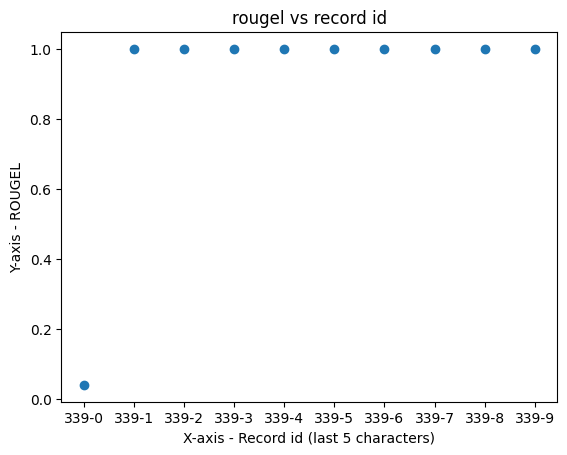

In [33]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - ROUGEL")
plt.title("rougel vs record id")

# Display the graph
plt.show()

Plot rougelsum metrics against records

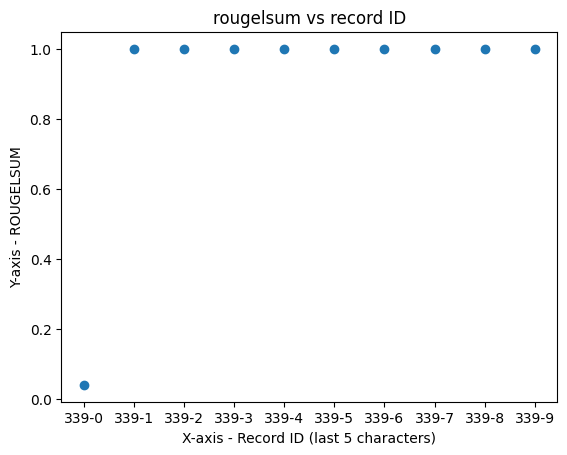

In [34]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record ID (last 5 characters)")
plt.ylabel("Y-axis - ROUGELSUM")
plt.title("rougelsum vs record ID")

# Display the graph
plt.show()

# See factsheets information <a name="factsheetsspace"></a>

In [35]:
factsheets_url = f"{DATAPLATFORM_URL.replace('api.', '')}/wx/prompt-details/{project_pta_id}/factsheet?context=wx&project_id={PROJECT_ID}"

print(f"User can navigate to the published facts in project {factsheets_url}")

User can navigate to the published facts in project https://dataplatform.cloud.ibm.com/wx/prompt-details/012db72c-7f52-4691-8f6b-5af51bae7cc4/factsheet?context=wx&project_id=1bed2bf0-2a16-4ee5-a017-347939fb4456


# Evaluate Prompt template from space <a name="evaluatespace"></a>

Now, we can promote the created prompt template asset to space and perform similar actions.

# Promote PTA to space <a name="promottospace"></a> 

Below cell promotes the prompt template asset from the project to the space.

In [36]:
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True

url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL ,project_pta_id)

params = {
    "project_id":PROJECT_ID
}

payload = {
    "space_id": space_id
}
response = requests.post(url, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'05ba7fd8-afaa-4c4b-93de-a13ced610410'

# Create deployment for prompt template asset in space <a name="ptadeployment"></a>

To create a subscription from space, it is necessary to create a deployment for prompt template assets in spaces.

In [37]:
DEPLOYMENTS_URL = WML_CREDENTIALS["url"] + "/ml/v4/deployments"

payload = {
    "prompt_template": {
      "id": space_pta_id
    },
    "detached": {
    },
    "base_model_id": "meta-llama/llama-3-70b-instruct",
    "description": "rag qa deployment",
    "name": "TEST model deployment_DO_NOT_USE_v93",
    "space_id": space_id
}

version = "2023-07-07" # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {
    "version":version,
    "space_id":space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

7ea01cc6-e4dd-4f3d-a892-ab8b1521c897


# Setup the prompt template asset in space for evaluation with supported monitor dimensions <a name="ptaspace"></a>

The prompt template assets from space is only supported with [`pre_production` and `production`] operational space IDs. Running the below cell will create a `pre_production` type subscription from the prompt template asset promoted to the space. The `problem_type` value should depend on the task type specified in the prompt template asset.

In [39]:
label_column = "answer"
context_fields = ["context1", "context2", "context3"]
question_field = "question"
operational_space_id = "pre_production"
problem_type= "retrieval_augmented_generation"
input_data_type= "unstructured_text"

monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration":{        
            }
        }
    },
    #####################################################################################
    #For production flow add and configure the following drift monitor
    ######################################################################################
    # "drift_v2": {
    #     "thresholds": [
    #         {
    #             "metric_id": "confidence_drift_score",
    #             "type": "upper_limit",
    #             "value": 0.05
    #         },
    #         {
    #             "metric_id": "prediction_drift_score",
    #             "type": "upper_limit",
    #             "value": 0.05
    #         },
    #         {
    #             "metric_id": "input_metadata_drift_score",
    #             "specific_values": [
    #                 {
    #                     "applies_to": [
    #                         {
    #                             "type": "tag",
    #                             "value": "subscription",
    #                             "key": "field_type"
    #                         }
    #                     ],
    #                     "value": 0.05
    #                 }
    #             ],
    #             "type": "upper_limit"
    #         },
    #         {
    #             "metric_id": "output_metadata_drift_score",
    #             "specific_values": [
    #                 {
    #                     "applies_to": [
    #                         {
    #                             "type": "tag",
    #                             "value": "subscription",
    #                             "key": "field_type"
    #                         }
    #                     ],
    #                     "value": 0.05
    #                 }
    #             ],
    #             "type": "upper_limit"
    #         }
    #     ],
    #     "parameters": {
    #         "min_samples": 10,
    #         "train_archive": True
    #     }
    # }
}


response = wos_client.wos.execute_prompt_setup(prompt_template_asset_id = space_pta_id, 
                                                                   space_id = space_id,
                                                                   deployment_id = deployment_id,
                                                                   label_column = label_column,
                                                                   context_fields=context_fields,     
                                                                   question_field = question_field,   
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()




 Waiting for end of adding prompt setup 05ba7fd8-afaa-4c4b-93de-a13ced610410 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '05ba7fd8-afaa-4c4b-93de-a13ced610410',
 'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
 'deployment_id': '7ea01cc6-e4dd-4f3d-a892-ab8b1521c897',
 'service_provider_id': 'd7f990e5-5547-4dd7-8b68-9760dc6682b8',
 'subscription_id': '5a74b2ff-76d2-487d-9481-a6837a19bd04',
 'mrm_monitor_instance_id': '5105ce2f-58d5-4c7c-953c-6121fd0c0c15',
 'start_time': '2024-08-08T15:02:31.944472Z',
 'end_time': '2024-08-08T15:02:45.268695Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can read the prompt setup task and check its status

In [40]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(prompt_template_asset_id = space_pta_id,
                                                             deployment_id = deployment_id,
                                                             space_id = space_id)

result = response.result
result_json = result._to_dict()
result_json

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method


{'prompt_template_asset_id': '05ba7fd8-afaa-4c4b-93de-a13ced610410',
 'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
 'deployment_id': '7ea01cc6-e4dd-4f3d-a892-ab8b1521c897',
 'service_provider_id': 'd7f990e5-5547-4dd7-8b68-9760dc6682b8',
 'subscription_id': '5a74b2ff-76d2-487d-9481-a6837a19bd04',
 'mrm_monitor_instance_id': '5105ce2f-58d5-4c7c-953c-6121fd0c0c15',
 'start_time': '2024-08-08T15:02:31.944472Z',
 'end_time': '2024-08-08T15:02:45.268695Z',
 'status': {'state': 'FINISHED'}}

### Read subscription id from prompt setup

Once prompt setup status is finished, Read the subscription id from it.

In [42]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'5a74b2ff-76d2-487d-9481-a6837a19bd04'

## Below segment is required only if the user chooses PRODUCTION SPACE <a name="Prod"></a>

Now that the WML service has been bound and the subscription has been created, we need to score the prompt template asset. The downloaded csv is used to construct the payload as well as feedback for the deployment.

In [ ]:
import csv

feature_fields = context_fields + [question_field]
prediction = "generated_text"

pl_data = []
prediction_list = []

with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        predicted_val = row[prediction]
        prediction_list.append(predicted_val)
        response = {
            "results": [
                {
                    prediction: predicted_val
                }
            ]
        }
        record = {"request": request, "response": response}
        pl_data.append(record)
pl_data

### Generating additional payload data to enable drift(`Prod` only)

To enable drift there should be minimum 100 records in the payload table. The below cell duplicates the scored records and create another 100 records for adding to the payload table

In [72]:
import copy
additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 10
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 100 additional payload data


### Adding payload data

Below cell reads the payload data set id from the subscription. 

In [73]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  9ad2caa4-4098-477c-9953-04a564bfff92


Add additioanl payload data to enable drift V2

In [74]:
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=additional_pl_data,background_mode=False)
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))




 Waiting for end of storing records with request id: 3d2a6be2-245e-4d9f-8eff-11a40b2daafc 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 100


Now a total of 110 records should be available within the payload table. But in case if auto payload logging fails to transmit the scored records to the payload logging table, the following code can be used to manually add payload data to the table.

In [75]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count < 110:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=pl_data,background_mode=False)
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 100
Payload logging did not happen, performing explicit payload logging.



 Waiting for end of storing records with request id: 35ed7600-76ea-4dcf-adf7-6755d55999e7 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 110


### Adding feedback data

Below cell reads the feedback data set id from the subscription. 

In [76]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
feedback_data_set_id = None
feedback_data_set_id = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if feedback_data_set_id is None:
    print("Feedback data set not found. Please check subscription status.")
else:
    print("Feedback data set id: ", feedback_data_set_id)

Feedback data set id:  4b5523a6-5830-465b-8cec-178f6f84cba2


The provided code generates feedback data based on the downloaded CSV file and the scored response.

In [77]:

test_data_content = []
feature_fields = context_fields + [question_field]   #For Alternative Dataset
prediction_list = llm_data["generated_text"].tolist()

for _, row in llm_data.iterrows():
    # Read each row from the DataFrame and add label and prediction values
    result_row = [row[key] for key in feature_fields if key in row]
    result_row.append(row[label_column])
    result_row.append(row["generated_text"])
    test_data_content.append(result_row)

if len(test_data_content) == 10: # 10 records are there in the downloaded CSV
    print("generated feedback data from DataFrame")
else:
    print("Failed to generate feedback data from DataFrame, kindly verify the DataFrame content")

fields = feature_fields.copy()
fields.append(label_column)
fields.append("_original_prediction")
feedback_data = [
    {
        "fields": fields,
        "values": test_data_content
    }
]

feedback_data

generated feedback data from DataFrame


[{'fields': ['context1',
   'context2',
   'context3',
   'question',
   'answer',
   '_original_prediction'],
  'values': [["\n<t1></t1>\nAt Bingle, we don't have the option to change your policy from Comprehensive to Third Party Property Damage, or vice versa. If you want to change the level of cover, youâ€™ll need to start up a NEW Comprehensive Insurance (https://online.bingle.com.au/motor/pub/binglequote?productType=comprehensive) or Third Party Property Damage (https://online.bingle.com.au/motor/pub/binglequote?productType=thirdParty) policy online, and cancel (https://online.bingle.com.au/onesuncorp) the existing policy. Cancelling within the cooling off period. If you change your mind within 21 days of when your policy starts, and you haven't made a claim, you can cancel your policy and receive a full refund. Just make sure you select 'Cooling off' as the reason for the cancellation, and select the start date of your policy as the cancellation date. If a refund is due to you, t

The following code can be used to manually add feedback data to the table.

In [78]:
wos_client.data_sets.store_records(data_set_id=feedback_data_set_id, request_body=feedback_data,background_mode=False)
time.sleep(5)
fb_records_count = wos_client.data_sets.get_records_count(feedback_data_set_id)
time.sleep(10)
print("Number of records in the feedback logging table: {}".format(fb_records_count))




 Waiting for end of storing records with request id: cce8d426-62d4-453b-8d61-54273b6dfa62 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the feedback logging table: 10


## Show all the monitor instances of the subscription
The following cell lists the monitors present in the `pre_production`/`production` subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [43]:
import time
time.sleep(10)
wos_client.monitor_instances.show(target_target_id = prod_subscription_id)

4761e11b-18ab-4e88-a79d-b0e26609af5f,active,5a74b2ff-76d2-487d-9481-a6837a19bd04,subscription,generative_ai_quality,2024-08-08 15:02:36.567000+00:00,ffc3acd9-c2da-4c95-b89d-9e9460d72642
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,5a74b2ff-76d2-487d-9481-a6837a19bd04,subscription,model_health,2024-08-08 15:02:37.317000+00:00,f7d09fa0-25cb-4840-9db5-979dac2d6fa6
4761e11b-18ab-4e88-a79d-b0e26609af5f,active,5a74b2ff-76d2-487d-9481-a6837a19bd04,subscription,mrm,2024-08-08 15:02:37.965000+00:00,5105ce2f-58d5-4c7c-953c-6121fd0c0c15


### Read the MRM monitor instance ID of PTA subscription deployed in space

Evaluating the test data against the prompt template subscription requires the monitor instance ID of MRM.

In [44]:
monitor_definition_id = "mrm"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           space_id=space_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'5105ce2f-58d5-4c7c-953c-6121fd0c0c15'

### Evaluate the prompt template subscription from space

The following cell will assess subscription of the prompt template asset and produce relevant measurements for the configured monitor. The data to be evaluated are already uploaded to payload and feedback table.

In [45]:
#####################################################################################
######### For pre_production flow 
######################################################################################
response  = wos_client.monitor_instances.mrm.evaluate_risk(
                                                    monitor_instance_id=mrm_monitor_id,
                                                    body=body, 
                                                    test_data_set_name=test_data_set_name,
                                                    test_data_path=test_data_path,        
                                                    content_type=content_type,            
                                                    includes_model_output=True,           
                                                    space_id = existing_space_id,
                                                    background_mode = False
                                                    )




 Waiting for risk evaluation of MRM monitor 5105ce2f-58d5-4c7c-953c-6121fd0c0c15 




upload_in_progress.
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




In [ ]:
#####################################################################################
######### For production flow 
######################################################################################
# response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
#                                                     body = body,
#                                                     space_id = space_id,
#                                                     evaluation_tests = ["generative_ai_quality", "model_health","drift_v2"],
#                                                     background_mode = False)

### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results of PTA from space are now available for review,

In [46]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, space_id = space_id)
response.result.to_dict()

{'metadata': {'id': '9e56f7f7-c7f5-482a-891d-ad3d2c894e73',
  'created_at': '2024-08-08T15:13:58.914Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'deployment_id': '7ea01cc6-e4dd-4f3d-a892-ab8b1521c897',
   'evaluation_start_time': '2024-08-08T15:13:43.017323Z',
   'evaluator_user_key': '77f1cd9d-157a-400c-9992-203cdeca6eda',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '2514d35c-acfe-4809-b508-2a16791f6bd1',
   'prompt_template_asset_id': '05ba7fd8-afaa-4c4b-93de-a13ced610410',
   'prompt_template_details': {'pta_resource_key': 'eae7b8d10bde76ee8c623248bdb06f3192b4572e244641740a88b345262a06c1'},
   'space_id': 'a4a76fad-a549-43cd-9d1d-2c17b15f009e',
   'user_iam_id': 'IBMid-694000BNQ7',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at

## Display the Model Risk metrics

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [47]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, space_id=space_id)

2024-08-08 15:13:58.998000+00:00,tests_passed,2514d35c-acfe-4809-b508-2a16791f6bd1,1.0,None,None,['test_data_set_name:data'],mrm,5105ce2f-58d5-4c7c-953c-6121fd0c0c15,9e56f7f7-c7f5-482a-891d-ad3d2c894e73,subscription,5a74b2ff-76d2-487d-9481-a6837a19bd04
2024-08-08 15:13:58.998000+00:00,tests_run,2514d35c-acfe-4809-b508-2a16791f6bd1,1.0,None,None,['test_data_set_name:data'],mrm,5105ce2f-58d5-4c7c-953c-6121fd0c0c15,9e56f7f7-c7f5-482a-891d-ad3d2c894e73,subscription,5a74b2ff-76d2-487d-9481-a6837a19bd04
2024-08-08 15:13:58.998000+00:00,tests_skipped,2514d35c-acfe-4809-b508-2a16791f6bd1,2.0,None,None,['test_data_set_name:data'],mrm,5105ce2f-58d5-4c7c-953c-6121fd0c0c15,9e56f7f7-c7f5-482a-891d-ad3d2c894e73,subscription,5a74b2ff-76d2-487d-9481-a6837a19bd04
2024-08-08 15:13:58.998000+00:00,tests_failed,2514d35c-acfe-4809-b508-2a16791f6bd1,0.0,None,None,['test_data_set_name:data'],mrm,5105ce2f-58d5-4c7c-953c-6121fd0c0c15,9e56f7f7-c7f5-482a-891d-ad3d2c894e73,subscription,5a74b2ff-76d2-487d-9481-a6837a19bd04


## Display the Generative AI Quality metrics

### Read the Generative ai quality monitor instance id

Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [48]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'ffc3acd9-c2da-4c95-b89d-9e9460d72642'

Displaying the monitor metrics of GenAIQ generated through the risk evaluation.

In [ ]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, space_id=space_id)

## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [50]:
result = wos_client.data_sets.list(target_target_id = prod_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'e2836022-e122-4a79-85a0-530ee0ac21b7'

Displaying record level metrics for generative ai quality

In [ ]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

# Plot rougel and rougelsum metrics against records <a name="plotspace"></a>

In [52]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

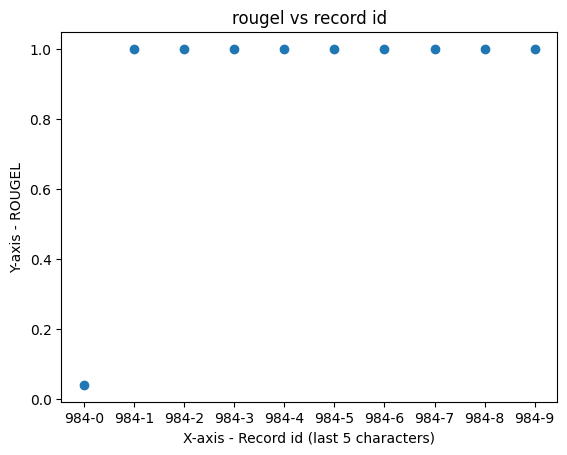

In [53]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

Plot rougelsum metrics against records

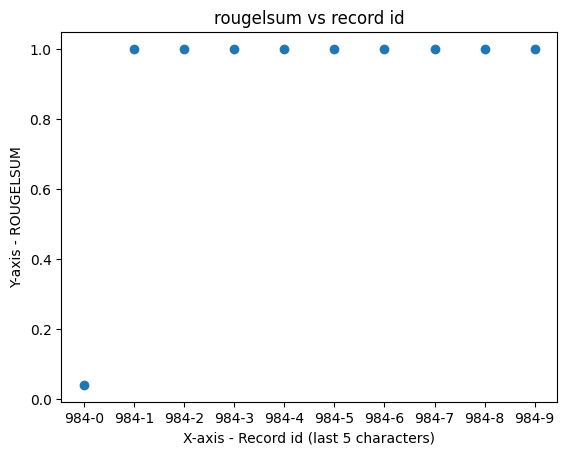

In [54]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

## Display the Drift V2 metrics (`Prod` only)

### Read the Drift V2 monitor instance id

Monitor instance ID of Drift V2 metrics is required for reading its metrics.

In [91]:
monitor_definition_id = "drift_v2"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
drift_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
drift_monitor_id

'58817478-f730-4f76-b3b4-c08476636a3b'

Displaying the monitor metrics of Drift V2 generated through the risk evaluation.

In [92]:
time.sleep(5)
wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_monitor_id, space_id=space_id)

# User can navigate to see the published facts in space <a name="factsheetsproject"></a>

In [56]:
factsheets_url = "https://dataplatform.cloud.ibm.com/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(deployment_id, space_id)

print("User can navigate to the published facts in space {}".format(factsheets_url))

User can navigate to the published facts in space https://dataplatform.cloud.ibm.com/ml-runtime/deployments/7ea01cc6-e4dd-4f3d-a892-ab8b1521c897/details?space_id=a4a76fad-a549-43cd-9d1d-2c17b15f009e&context=wx&flush=true


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now navigate to the prompt template asset in your project / spaceand click on the Evaluate tab to visualise the results on the UI.